Importing modules

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mode
from pathlib import Path
from os.path import join as pjoin

import chiCa
from chiCa.visualization_utils import separate_axes
from spks.sync import load_ni_sync_data,interp1d
from spks.event_aligned import compute_firing_rate
from spks.clusters import Clusters

from utils import *
from viz import *


%matplotlib widget

Loading nidaq and behavior data

In [47]:
animal = 'GRB006'
session = '20240716_151257'
sessionpath = Path(f'/home/data/{animal}/{session}/')
sync_port = 0 # this is where the SMA of the probe is connected

print('Loading nisync data...')
(nionsets,nioffsets),(nisync,nimeta),(apsyncdata) = load_ni_sync_data(sessionpath=sessionpath)
aponsets = apsyncdata[0]['file0_sync_onsets'][6] # this should be the same for you, its where the sync is on the probe

corrected_onsets = {}
corrected_offsets = {} # This is a dictionary with the digital events that were connected to the breakout box.
for k in nionsets.keys():
    corrected_onsets[k] = interp1d(nionsets[sync_port],aponsets,fill_value='extrapolate')(nionsets[k]).astype('uint64')
    corrected_offsets[k] = interp1d(nionsets[sync_port],aponsets,fill_value='extrapolate')(nioffsets[k]).astype('uint64')
del k

# if you need analog channels those are in "nisync"
nitime = interp1d(nionsets[sync_port],aponsets,fill_value='extrapolate')(np.arange(len(nisync)))

# everything is in samples, use this sampling rate
srate = apsyncdata[0]['sampling_rate']  
t = nitime/srate
frame_rate = mode(1/(np.diff(corrected_onsets[1])/srate)) #corrected_onsets[1] are the frame samples, [2] are the trial start samples
analog_signal = nisync[:, 0] # analog stim signal
print('Success!\n-----')

# storing digital events in seconds
print('Loading nidaq events...')
trial_starts = corrected_onsets[2]/srate

if len(corrected_onsets.keys()) > 3:
    print('Port events found. Proceeding with extracting them...')
    left_port_entries = corrected_onsets[3]/srate
    left_port_exits = corrected_offsets[3]/srate
    center_port_entries = corrected_onsets[4]/srate
    center_port_exits = corrected_offsets[4]/srate
    right_port_entries = corrected_onsets[5]/srate
    right_port_exits = corrected_offsets[5]/srate

    # for simplicity later
    port_events = {
        "center_port": {
            "entries": center_port_entries,
            "exits": center_port_exits
        },
        "left_port": {
            "entries": left_port_entries,
            "exits": left_port_exits
        },
        "right_port": {
            "entries": right_port_entries,
            "exits": right_port_exits
        }
    }

    behavior_data = chiCa.load_trialdata(pjoin(sessionpath, f'chipmunk/{animal}_{session}_chipmunk_DemonstratorAudiTask.mat'))

    # get trialized timestamps for task events
    trial_ts = get_trial_ts(trial_starts, detect_stim_events(t, srate, analog_signal, amp_threshold=5000), behavior_data, port_events)
    trial_ts.insert(trial_ts.shape[1], 'response', trial_ts.apply(get_response_ts, axis=1))
    trial_ts.insert(trial_ts.shape[1], 'stationary_stims', trial_ts.apply(get_stationary_stims, axis=1))
    trial_ts.insert(trial_ts.shape[1], 'movement_stims', trial_ts.apply(get_movement_stims, axis=1))
    print('Success!')
else:
    print('No port events registered in this session. Proceeding without them...')
    behavior_data = chiCa.load_trialdata(pjoin(sessionpath, f'chipmunk/{animal}_{session}_chipmunk_DemonstratorAudiTask.mat'))
    trial_ts = get_trial_ts(trial_starts, detect_stim_events(t, srate, analog_signal, amp_threshold=5000), behavior_data)
    trial_ts.insert(trial_ts.shape[1], 'stationary_stims', trial_ts.apply(get_stationary_stims, axis=1))
    trial_ts.insert(trial_ts.shape[1], 'movement_stims', trial_ts.apply(get_movement_stims, axis=1))
    print('Success!')

Loading nisync data...
Success!
-----
Loading nidaq events...
Port events found. Proceeding with extracting them...


/opt/conda/envs/spks-gabriel/lib/python3.12/site-packages/chiCa/chipmunk_analysis_tools.py:321: UserWarning: Found multisensory trials, assumed synchronous condition
  warnings.warn('Found multisensory trials, assumed synchronous condition')


Success!
-----


Inter stimulus event interval histogram

In [ ]:
# plt.figure()
# plt.hist(np.diff(np.hstack(trial_ts.stim_ts)), np.arange(0, 0.7, 0.02), color='k', alpha = 0.5)
# plt.vlines(np.arange(0, 0.7, 0.02), 0, 100, color='k', alpha = 1, linestyles='dotted')
# plt.xlabel('inter stim event interval (s)')
# plt.ylabel('count')
# plt.title(f'{animal} - {session}')
# plt.tight_layout()

Loading and filtering KS results

In [44]:
kilosort_path = Path(f'/home/data/{animal}/{session}/kilosort2.5/imec0/')
sc = np.load(pjoin(kilosort_path, 'spike_clusters.npy')) #KS clusters
ss = np.load(pjoin(kilosort_path, 'spike_times.npy')) #KS spikes (in samples)
st = ss/srate #conversion from spike samples to spike times

clu = Clusters(folder = kilosort_path, get_waveforms=False, get_metrics=True, load_template_features=True)

good_unit_ids, n_units = get_good_units(clusters_obj = clu, spike_clusters = sc)
print(f'# good units: {n_units}')


# good units: 206


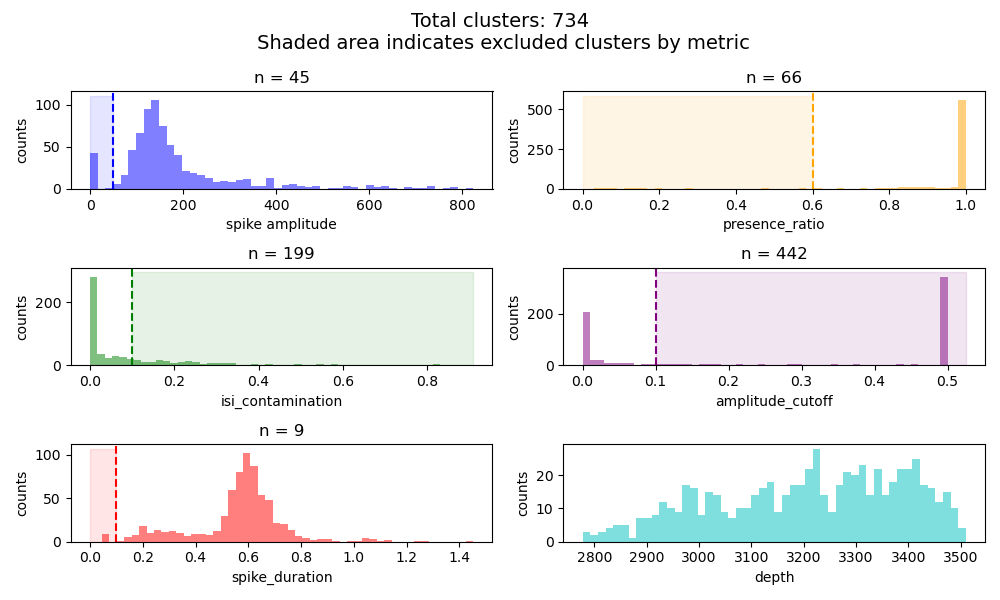

In [45]:
plot_cluster_info_histograms(clu)

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1952681/2093300346.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Depth from probe tip ($\mu$m)')


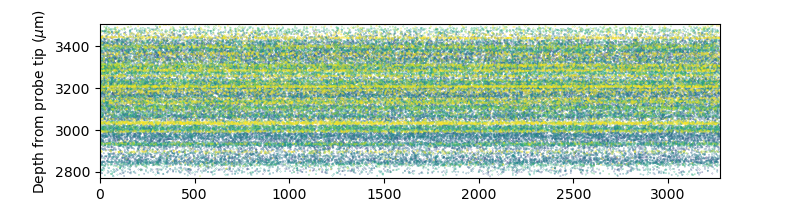

In [46]:
# there are multiple ways to plot the drift raster one is using the Clusters object.
plt.figure(figsize = [8,2])

clu.plot_drift_map(clim = [0,2000])

plt.ylabel('Depth from probe tip ($\mu$m)')
plt.xlabel('Time (min)');

Static population PSTH plotting

In [ ]:
binwidth_ms = 5
window_ms = 20
tpre = 0.03
tpost = 0.06

population_timestamps = st[good_unit_ids]
single_unit_timestamps = get_cluster_spike_times(spike_times = st, spike_clusters = sc, good_unit_ids = good_unit_ids)

psth, unit_fr = get_population_firing_rate(event_times = np.hstack(trial_ts.first_stim_ts),
                                  spike_times = single_unit_timestamps,
                                  tpre = tpre,
                                  tpost = tpost,
                                  binwidth_ms = binwidth_ms, 
                                  window_ms = window_ms)
n_stims = len(psth)

plt.figure(figsize=(4, 4))
plot_psth(mean_sem_func = compute_mean_sem(unit_fr),
          pre_seconds = tpre, 
          post_seconds = tpost, 
          binwidth_ms = binwidth_ms, 
          window_ms = window_ms, 
          xlabel = 'time from first stim event (s)', 
          ylabel = 'population firing rate (Hz)', 
          fig_title = f"{n_units} units - {n_stims} stims")
separate_axes(plt.gca())

In [ ]:
binwidth_ms = 10
window_ms = 50
tpre = 0.5
tpost = 0.5

_ , norm_fr = get_population_firing_rate(event_times = np.hstack(trial_ts.first_stim_ts),
                                  spike_times = single_unit_timestamps,
                                  tpre = tpre,
                                  tpost = tpost,
                                  binwidth_ms = binwidth_ms, 
                                  window_ms = window_ms,
                                  normalize = True)

# print(norm_fr.shape)
# fig, axs = plt.subplots(1,2,figsize=(8,4))
# iunit=150
# # plt.plot()
# axs[0].plot(np.mean(norm_fr, axis = 0), label='norm', color='b')
# # axs[0].plot(norm_fr[iunit], label='unit example', color='k')
# # axs[1].plot(fixed_unit_fr[iunit], label='unit example', color='k')
# axs[1].plot(np.mean(unit_fr, axis = 0), label='raw', color='r')
# fig.legend()
plt.figure(figsize=(2,4))
# for unit in norm_fr:
#     plt.plot(moving_average(unit, int(window_ms / binwidth_ms)))
# plt.ylim([0, 2])
# # np.mean(norm_fr, axis = 0)
# plt.imshow(norm_fr, aspect='auto')
# plt.figure(figsize=(2,6))
plt.imshow(norm_fr, aspect='auto', extent=[-tpre,tpost,0,len(norm_fr)],cmap = 'RdBu_r')
plt.ylabel('Units')
plt.xlabel('time (s)')
plt.title('first stim onset', fontsize=10)
plt.vlines(0, 0, len(norm_fr), linestyles='dotted', color='k')
plt.tight_layout()

Stationary and moving stims

In [ ]:
binwidth_ms = 5
window_ms = 20
tpre = 0.025
tpost = 0.055

_, stationary_norm_fr = get_population_firing_rate(event_times = np.hstack(trial_ts[trial_ts.trial_outcome.isin([0,1])].stationary_stims),
                                  spike_times = single_unit_timestamps,
                                  tpre = tpre,
                                  tpost = tpost,
                                  binwidth_ms = binwidth_ms,
                                  window_ms = window_ms,
                                  normalize = False)

_, movement_norm_fr = get_population_firing_rate(event_times = np.hstack(trial_ts[trial_ts.trial_outcome.isin([0,1])].movement_stims),
                                  spike_times = single_unit_timestamps,
                                  tpre = tpre,
                                  tpost = tpost,
                                  binwidth_ms = binwidth_ms,
                                  window_ms = window_ms,
                                  normalize = False)

plt.figure(figsize=(4,4))
plot_psth(compute_mean_sem(stationary_norm_fr), tpre, tpost, binwidth_ms, window_ms, 'time from stims (s)', 'population firing rate (sp/s)', color = 'r', data_label = f'stationary', vline=False)
plot_psth(compute_mean_sem(movement_norm_fr), tpre, tpost, binwidth_ms, window_ms, 'time from stims (s)', 'population firing rate (sp/s)', color = 'g', data_label = f'movement', vline=False)
# plt.yticks(np.arange(5,13,1))
# plt.xticks(np.arange(-0.03, 0.06, 0.01))
separate_axes(plt.gca())
plt.vlines(0, ymin=plt.gca().get_ylim()[0], ymax=plt.gca().get_ylim()[1], color='k', linestyles='dashed', alpha=0.5)

Stim responses by outcome

In [ ]:
#loop over all outcomes, plot pop psth for those stim events, and save fig
binwidth_ms = 5
window_ms = 20
tpre = 0.05
tpost = 0.05

plt.figure(figsize=(5, 5))
for outcome, c in zip([0, 1], ['k', 'g']): #zip(np.unique(trial_ts.trial_outcome), ['b', 'k', 'r', 'y'])
    # ts = np.hstack(trial_ts[trial_ts.trial_outcome == outcome].stim_ts)
    ts = np.hstack([stims[-1] for stims in trial_ts[trial_ts.trial_outcome == outcome].stim_ts])
    # ts = np.hstack([exits[-1] if len(exits) > 1 else exits[0] for exits in trial_ts[trial_ts.trial_outcome == outcome].response])
    _, unit_fr = get_population_firing_rate(event_times = ts,
                                    spike_times = single_unit_timestamps,
                                    tpre = tpre,
                                    tpost = tpost,
                                    binwidth_ms = binwidth_ms,
                                    window_ms = window_ms,
                                    normalize = False)
    # norm_fr = np.array([unit/unit.max() for unit in unit_fr if not unit.all() == 0])
    # psth = np.mean(norm_fr, axis = 0)
    # continue
    n_units = len(unit_fr)

    if outcome == 0:
        txt = 'unrewarded'
    elif outcome == 1:
        txt = 'rewarded'
    elif outcome == -1:
        txt = 'early withdrawal'
    elif outcome == 2:
        txt = 'no choice'

    plot_psth(mean_sem_func = compute_mean_sem(unit_fr), 
              pre_seconds = tpre, 
              post_seconds = tpost, 
              binwidth_ms = binwidth_ms, 
              window_ms = window_ms,
              xlabel = 'time from response onset (s)',
              ylabel = 'normalized firing rate (sp/s)',
              fig_title = f"{n_units} neurons",
              data_label = f"{txt}",
              color=c)
    # filename = f"pop_stim_kernel_{rate}_Hz.png"
    # save_dir = Path('/home/gabriel/lib/lab-projects/ephys/figures/stim_kernels_per_rate/')
    # filepath = os.path.join(save_dir, filename)
    # plt.savefig(filepath)
plt.legend()

In [ ]:
norm_fr.shape

Aligning activity to multiple task events

In [ ]:
timepoints = dict()
initiation = []
stimulus = []
action = []
response = []

for _ , trial in trial_ts[trial_ts.trial_outcome.isin([0,1])].iterrows():
    initiation.append(trial.center_port_entries[-1])
    stimulus.append(trial.first_stim_ts)
    action.append(trial.center_port_exits[-1])
    response.append(trial.response)

timepoints = pd.DataFrame(dict({'initiation' : initiation, 'stimulus' : stimulus, 'action' : action, 'response' : response}))
n_trials = len(timepoints)
binwidth_ms = 5
window_ms = 50
# tpre = 0.025
# tpost = 0.055

# single_unit_timestamps = get_cluster_spike_times(spike_times = st, spike_clusters = sc, good_unit_ids = good_unit_ids)

#initiation
fig, axs = plt.subplots(1,4,figsize=(16, 4))
psth = get_population_firing_rate(event_times = timepoints.initiation,
                                  spike_times = single_unit_timestamps,
                                  tpre = 1,
                                  tpost = 0,
                                  binwidth_ms = binwidth_ms,
                                  window_ms = window_ms,
                                  normalize = True)
plot_psth(compute_mean_sem(psth), 
          pre_seconds = 1, 
          post_seconds = 0,
          binwidth_ms = binwidth_ms,
          window_ms = window_ms,
          xlabel = 'trial start (s)',
          ylabel = 'normalized firing rate (sp/s)',
          ax=axs[0])
separate_axes(axs[0])

#stimulus
psth = get_population_firing_rate(event_times = timepoints.stimulus,
                                  spike_times = single_unit_timestamps,
                                  tpre = 0.04,
                                  tpost = 0.06,
                                  binwidth_ms = binwidth_ms,
                                  window_ms = window_ms,
                                  normalize = True)
plot_psth(compute_mean_sem(psth), 
          pre_seconds = 0.04, 
          post_seconds = 0.06,
          binwidth_ms = binwidth_ms,
          window_ms = window_ms,
          xlabel = 'stimulus onset (s)',
          ylabel = 'normalized firing rate (sp/s)',
          ax=axs[1])
separate_axes(axs[1])

#action
psth = get_population_firing_rate(event_times = timepoints.action,
                                  spike_times = single_unit_timestamps,
                                  tpre = 0.5,
                                  tpost = 0.5,
                                  binwidth_ms = binwidth_ms,
                                  window_ms = window_ms,
                                  normalize = True)
plot_psth(compute_mean_sem(psth), 
          pre_seconds = 0.5, 
          post_seconds = 0.5,
          binwidth_ms = binwidth_ms,
          window_ms = window_ms,
          xlabel = 'action onset (s)',
          ylabel = 'normalized firing rate (sp/s)',
          ax=axs[2])    
separate_axes(axs[2])

#response
psth = get_population_firing_rate(event_times = timepoints.response,
                                  spike_times = single_unit_timestamps,
                                  tpre = 0.05,
                                  tpost = 0.2,
                                  binwidth_ms = binwidth_ms,
                                  window_ms = window_ms,
                                  normalize = True)
plot_psth(compute_mean_sem(psth), 
          pre_seconds = 0.05, 
          post_seconds = 0.2,
          binwidth_ms = binwidth_ms,
          window_ms = window_ms,
          xlabel = 'outcome onset (s)',
          ylabel = 'normalized firing rate (sp/s)',
          ax=axs[3])                                  
separate_axes(axs[3])

if window_ms:
    fig.suptitle(f"{n_units} units - {n_trials} trials - {binwidth_ms} ms bins - {window_ms} ms smoothing window")
else:
    fig.suptitle(f"{n_units} units - {n_trials} trials - {binwidth_ms} ms bins")
fig.tight_layout()

Single neuron interactive viewer

In [ ]:
binwidth_ms = 5
tpre = 0.025
tpost = 0.3


plt.figure(figsize=(4, 4))
# fig, axs = plt.subplots(1,2, figsize=(6,4))
individual_psth_viewer(event_times = trial_ts.first_stim_ts, 
                       single_unit_timestamps = single_unit_timestamps, 
                       pre_seconds = tpre, 
                       post_seconds = tpost, 
                       binwidth_ms = binwidth_ms, 
                       save_dir = Path('/home/gabriel/lib/lab-projects/ephys/figures/'),
                       fig_title = 'first stim onsets')

# individual_psth_viewer(event_times = trial_ts.first_stim_ts, 
#                        single_unit_timestamps = single_unit_timestamps, 
#                        pre_seconds = tpre, 
#                        post_seconds = tpost, 
#                        binwidth_ms = binwidth_ms, 
#                        save_dir = Path('/home/gabriel/lib/lab-projects/ephys/figures/'),
#                        fig_title = 'first stim onsets',
#                        ax = axs[1])